In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit, logit, comb
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import os
from statsmodels.stats.multitest import multipletests


import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/sc_splicing_regulation/utils/')
from utils_functions import *

sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/analysis_psix/utils/')
from misc_utils import *


In [2]:
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix/psix/')
import psix
psix_object = psix.Psix()
psix_object.adata.uns['psi'] = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova/skipped_exons_psi.tab', 
                                           sep='\t', index_col=0).T
# psix_object.adata.uns['latent'] = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova/rd_pc2.tab', 
#                                               sep='\t', index_col=0)
psix_object.compute_neighbors_psi(
    latent='/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/tiklova/rd_pc2.tab', 
    n_neighbors=100, remove_self=False)

slicing exons...


100%|██████████| 15680/15680 [02:29<00:00, 104.85it/s]

Successfully computed neighbors


In [5]:
psix_object.adata.uns['neighbors_psi']

,AF529169_nmdSE_1,AI413582_1,AI480526_1,AI597479_1,AI987944_1,AU021092_1,AU021092_3,AU022252_1,AU022252_2,AU022754_1,...,Zwint_2,Zyg11b_1,Zyx_1,Zyx_2,Zzef1_1,Zzz3_10,Zzz3_11,Zzz3_12,Zzz3_14,Zzz3_4
SRR7408400,0.535153,1.000000,0.335635,0.990685,1.000000,NaN,NaN,1.000000,0.925323,NaN,...,0.999117,1.000000,0.626815,0.775934,1.000000,1.000000,1.000000,0.830439,0.514888,0.892535
SRR7408401,0.677757,0.984706,0.244804,0.992353,1.000000,NaN,NaN,0.971796,0.969432,NaN,...,1.000000,0.971613,0.777666,0.748140,1.000000,0.774605,0.828484,0.811741,0.541403,0.907360
SRR7408404,0.689676,0.985577,0.230180,0.991678,1.000000,NaN,NaN,0.971887,0.971686,NaN,...,1.000000,0.956394,0.788988,0.741857,1.000000,0.760632,0.818208,0.825208,0.539418,0.913399
SRR7408413,0.303361,0.978243,0.337786,0.978227,1.000000,NaN,NaN,0.913115,0.920274,NaN,...,1.000000,0.929237,0.769693,0.671932,1.000000,0.500903,0.722997,0.542458,0.764879,0.956212
SRR7408414,0.519723,0.979593,0.463359,1.000000,1.000000,NaN,NaN,0.938076,0.928041,NaN,...,1.000000,0.940952,0.788081,0.674801,1.000000,0.617341,0.822527,0.596368,0.743887,0.953822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7410094,0.265803,0.989846,0.737705,1.000000,0.929824,NaN,NaN,1.000000,1.000000,1.0,...,0.998973,1.000000,0.618485,0.915786,1.000000,0.921614,0.952835,0.822480,1.000000,1.000000
SRR7410095,0.389521,0.997105,0.545005,0.985640,0.907288,NaN,NaN,1.000000,0.959288,1.0,...,0.999007,1.000000,0.638702,0.638540,0.804913,0.907846,0.925383,0.923861,0.000000,0.915470
SRR7410096,0.447486,0.996416,0.656541,0.978314,0.901606,NaN,NaN,1.000000,0.941308,1.0,...,0.998757,1.000000,0.655006,0.617745,0.767601,0.906370,0.918142,1.000000,0.000000,0.883050
SRR7410097,0.285905,0.993882,0.802375,1.000000,0.891451,NaN,NaN,1.000000,1.000000,1.0,...,0.999221,1.000000,0.661940,0.840142,1.000000,1.000000,1.000000,0.842860,NaN,1.000000


In [2]:
data_dir = '/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/'
tiklova_mrna_event = pd.read_csv(data_dir + 'tiklova_neurogenesis/mrna_per_event.tab', sep='\t', index_col=0)
tiklova_rd = pd.read_csv('data/pc2_rd.tab.gz', sep='\t', index_col=0)
tiklova_PSI = pd.read_csv(data_dir + 'tiklova_neurogenesis/skipped_exons_psi.tab', sep='\t', index_col=0)
tiklova_psix = pd.read_csv('~/psix_d', sep='\t', index_col=0)
tiklova_pseudotime = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/pseudotime.tab', 
                                 sep='\t', index_col=0)

sig_exons = tiklova_psix.loc[(tiklova_psix.qvals <= 0.05) & (tiklova_psix.L_score > 0)].index

FileNotFoundError: [Errno 2] File psix/scvi5_batch.scores.txt does not exist: 'psix/scvi5_batch.scores.txt'

In [7]:
pc_all = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova/rd_pc2.tab', sep='\t', index_col=0)
psi_all = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova/skipped_exons_psi.tab', sep='\t', index_col=0)

In [13]:
[x for x in psi_all.index if 'Morf4l2' in x]

['Morf4l2_7', 'Morf4l2_9']

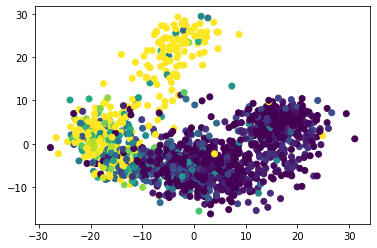

In [14]:
plt.scatter(pc_all.PC_1, pc_all.PC_2, c=psi_all.loc['Morf4l2_7'])

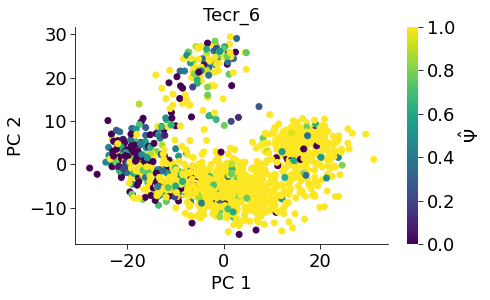

In [27]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(pc_all.PC_1, pc_all.PC_2, c=psi_all.loc['Zfp207_1'])
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Tecr_6', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



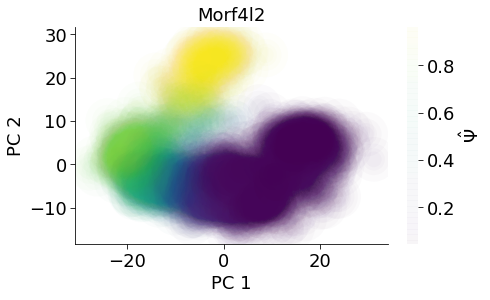

In [8]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(pc_all.PC_1, pc_all.PC_2, c=psix_object.adata.uns['neighbors_psi']['Morf4l2_7'], s=2000, alpha=0.02, linewidth=0)
ax.scatter(pc_all.PC_1, pc_all.PC_2, c=psix_object.adata.uns['neighbors_psi']['Morf4l2_7'], s=1000, alpha=0.02, linewidth=0)
ax.scatter(pc_all.PC_1, pc_all.PC_2, c=psix_object.adata.uns['neighbors_psi']['Morf4l2_7'], s=500, alpha=0.02, linewidth=0)
ax.scatter(pc_all.PC_1, pc_all.PC_2, c=psix_object.adata.uns['neighbors_psi']['Morf4l2_7'], s=250, alpha=0.02, linewidth=0)
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Morf4l2', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



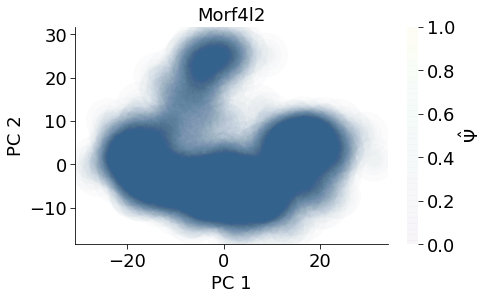

In [15]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
co = [psix_object.adata.uns['neighbors_psi']['Morf4l2_7'].mean()]*1527
sc = ax.scatter(pc_all.PC_1, pc_all.PC_2, c=co, vmin=0, vmax=1, s=2000, alpha=0.02, linewidth=0)
ax.scatter(pc_all.PC_1, pc_all.PC_2, c=co, vmin=0, vmax=1, s=1000, alpha=0.02, linewidth=0)
ax.scatter(pc_all.PC_1, pc_all.PC_2, c=co, vmin=0, vmax=1, s=500, alpha=0.02, linewidth=0)
ax.scatter(pc_all.PC_1, pc_all.PC_2, c=co, vmin=0, vmax=1, s=250, alpha=0.02, linewidth=0)
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Morf4l2', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



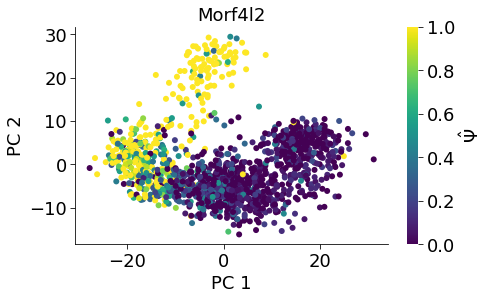

In [10]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(pc_all.PC_1, pc_all.PC_2, c=psi_all.loc['Morf4l2_7'], linewidth=0)
# ax.scatter(pc_all.PC_1, pc_all.PC_2, c=psi_all['Morf4l2_7'], s=1000, alpha=0.02, linewidth=0)
# ax.scatter(pc_all.PC_1, pc_all.PC_2, c=psi_all['Morf4l2_7'], s=500, alpha=0.02, linewidth=0)
# ax.scatter(pc_all.PC_1, pc_all.PC_2, c=psi_all['Morf4l2_7'], s=250, alpha=0.02, linewidth=0)
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Morf4l2', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



In [3]:
random_df = pd.DataFrame()
for mean_var in os.listdir('psix/scvi5_batch_pvals'):
    with open('psix/scvi5_batch_pvals/' + mean_var) as fh:
        random_scores = [np.float(x.rstrip()) for x in fh.readlines()]
    mean_var = mean_var.split('.')[0]
    random_df[mean_var] = random_scores
    

100%|██████████| 1988/1988 [00:09<00:00, 200.04it/s]


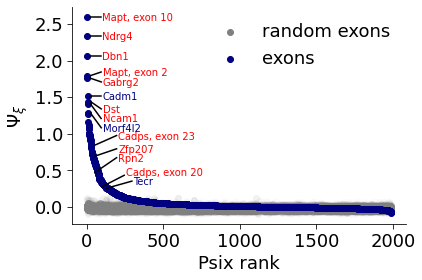

In [4]:
fig = plt.figure()
ax  = plt.subplot(1,1,1)
i = 1

ax.scatter([100], [-0.05], c='gray', label='random exons')

for mean_var in tqdm(tiklova_psix.sort_values('L_score')[::-1].bin):
    subset = np.random.choice(random_df[mean_var], 50, replace=False)
    ax.scatter([i]*50, subset, c='gray', alpha=0.02)
    i += 1


plt.text(100, tiklova_psix.loc['Mapt_1'].L_score-0.05, 'Mapt, exon 10', c='red')   
plt.plot([20, 90], [tiklova_psix.loc['Mapt_1'].L_score, tiklova_psix.loc['Mapt_1'].L_score],c='black')

plt.text(100, tiklova_psix.loc['Ndrg4_1'].L_score-0.05, 'Ndrg4', c='red')   
plt.plot([20, 90], [tiklova_psix.loc['Ndrg4_1'].L_score, tiklova_psix.loc['Ndrg4_1'].L_score],c='black')

plt.text(100, tiklova_psix.loc['Dbn1_1'].L_score-0.05, 'Dbn1', c='red')   
plt.plot([20, 90], [tiklova_psix.loc['Dbn1_1'].L_score, tiklova_psix.loc['Dbn1_1'].L_score],c='black')

plt.text(104, tiklova_psix.loc['Mapt_3'].L_score, 'Mapt, exon 2', c='red')    
plt.plot([24, 94], [tiklova_psix.loc['Mapt_3'].L_score, tiklova_psix.loc['Mapt_3'].L_score+0.05],c='black')
plt.text(105, tiklova_psix.loc['Gabrg2_1'].L_score-0.1, 'Gabrg2', c='red')   
plt.plot([25, 95], [tiklova_psix.loc['Gabrg2_1'].L_score, tiklova_psix.loc['Gabrg2_1'].L_score-0.05],c='black')



plt.text(104, tiklova_psix.loc['Cadm1_10'].L_score-0.05, 'Cadm1', c='navy')    
plt.plot([24, 94], [tiklova_psix.loc['Cadm1_10'].L_score, tiklova_psix.loc['Cadm1_10'].L_score],c='black')
plt.text(105, tiklova_psix.loc['Dst_5'].L_score-0.15, 'Dst', c='red')   
plt.plot([25, 95], [tiklova_psix.loc['Dst_5'].L_score, tiklova_psix.loc['Dst_5'].L_score-0.1],c='black')


plt.text(104, tiklova_psix.loc['Ncam1_6'].L_score-0.25, 'Ncam1', c='red')    
plt.plot([24, 94], [tiklova_psix.loc['Ncam1_6'].L_score, tiklova_psix.loc['Ncam1_6'].L_score-0.2],c='black')
plt.text(105, tiklova_psix.loc['Morf4l2_7'].L_score-0.25, 'Morf4l2', c='navy')   
plt.plot([25, 95], [tiklova_psix.loc['Morf4l2_7'].L_score, tiklova_psix.loc['Morf4l2_7'].L_score-0.2],c='black')

plt.text(305, tiklova_psix.loc['Tecr_6'].L_score+0.05, 'Tecr', c='navy')   
plt.plot([125, 295], [tiklova_psix.loc['Tecr_6'].L_score, tiklova_psix.loc['Tecr_6'].L_score+0.1],c='black')

plt.text(205, tiklova_psix.loc['Rpn2_3'].L_score+0.15, 'Rpn2', c='red')   
plt.plot([55, 195], [tiklova_psix.loc['Rpn2_3'].L_score, tiklova_psix.loc['Rpn2_3'].L_score+0.2],c='black')


plt.text(255, tiklova_psix.loc['Cadps_2'].L_score+0.15, 'Cadps, exon 20', c='red')   
plt.plot([105, 245], [tiklova_psix.loc['Cadps_2'].L_score, tiklova_psix.loc['Cadps_2'].L_score+0.15],c='black')

plt.text(205, tiklova_psix.loc['Cadps_7'].L_score+0.08, 'Cadps, exon 23', c='red')   
plt.plot([55, 195], [tiklova_psix.loc['Cadps_7'].L_score, tiklova_psix.loc['Cadps_7'].L_score+0.13],c='black')

plt.text(205, tiklova_psix.loc['Zfp207_1'].L_score+0.05, 'Zfp207', c='red')   
plt.plot([55, 195], [tiklova_psix.loc['Zfp207_1'].L_score, tiklova_psix.loc['Zfp207_1'].L_score+0.1],c='black')




ax.scatter(np.arange(1, len(tiklova_psix.index)+1), tiklova_psix.sort_values('L_score')[::-1].L_score, c = 'navy',
          label='exons')
    
plt.xlabel('Psix rank', fontsize=18)
plt.ylabel(r'$\Psi_{\xi}$', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
# plt.title('Neurogenesis exons', fontsize=18)
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
plt.legend(frameon=False, fontsize=18)

In [5]:
tiklova_psix_pca = pd.read_csv('psix/pc2.scores.txt', sep='\t', index_col=0)
tiklova_psix_scvi5 = pd.read_csv('psix/scvi5.scores.txt', sep='\t', index_col=0)


In [6]:
weyn_pvals = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_pvals.tab', sep='\t', index_col=0)
weyn_fdr = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_fdr.tab', sep='\t', index_col=0)
weyn_psi = pd.read_csv('~/sc_splicing_regulation/timeseries_neurogenesis/Weyn_psi.tab', sep='\t', index_col=0)

weyn_ds = get_averages_bulk(weyn_psi)
tiklova_kw = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', 
                                sep='\t', index_col=0)

tiklova_geary = pd.read_csv(
    '~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_autocorr/tiklova_GearyC_k100.tab',
    sep='\t', index_col=0)

tiklova_geary2 = pd.read_csv(
    'geary_c/tiklova_GearyC_scvi5_batch.tab',
    sep='\t', index_col=0)

from statsmodels.stats.multitest import multipletests

tiklova_geary['qvals'] = multipletests(tiklova_geary.pval, method='fdr_bh')[1]
tiklova_geary2['qvals'] = multipletests(tiklova_geary2.pval, method='fdr_bh')[1]

In [7]:
tiklova_meta = pd.read_csv('~/data_sc_regulation/tiklova/SraRunTable.txt', sep=',', index_col=0)

e13 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 13.5'] & tiklova_rd.index
e15 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 15.5'] & tiklova_rd.index
e18 = tiklova_meta.index[tiklova_meta.Age == 'embryonic day 18.5'] & tiklova_rd.index
p1 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 1'] & tiklova_rd.index
p7 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 7'] & tiklova_rd.index
p90 = tiklova_meta.index[tiklova_meta.Age == 'postnatal day 90'] & tiklova_rd.index

tiklova_labels = [e13, e15, e18, p1, p7, p90]


tiklova_kw_labels = run_kw_dset(tiklova_PSI, tiklova_labels, tiklova_psix.index)

In [8]:
one_v_one = 'brie2/label_v_label/'
tiklova_0v1 = pd.read_csv(one_v_one + 'l0v1.brie_quant_cell.brie_ident.tsv.gz', sep='\t', index_col=0)
tiklova_0v2 = pd.read_csv(one_v_one + 'l0v2.brie_quant_cell.brie_ident.tsv.gz', sep='\t', index_col=0)
tiklova_0v3 = pd.read_csv(one_v_one + 'l0v3.brie_quant_cell.brie_ident.tsv.gz', sep='\t', index_col=0)
tiklova_0v4 = pd.read_csv(one_v_one + 'l0v4.brie_quant_cell.brie_ident.tsv.gz', sep='\t', index_col=0)
tiklova_0v5 = pd.read_csv(one_v_one + 'l0v5.brie_quant_cell.brie_ident.tsv.gz', sep='\t', index_col=0)



tiklova_brie_pseudo = pd.read_csv('brie2/pseudotime/brie_quant_cell.brie_ident.tsv.gz', 
                                  sep='\t', index_col=0)



In [9]:
tiklova_one_v_one = pd.DataFrame()
tiklova_one_v_one['0v1'] = tiklova_0v1.neuro_pval
tiklova_one_v_one['0v2'] = tiklova_0v2.neuro_pval
tiklova_one_v_one['0v3'] = tiklova_0v3.neuro_pval
tiklova_one_v_one['0v4'] = tiklova_0v4.neuro_pval
tiklova_one_v_one['0v5'] = tiklova_0v5.neuro_pval
tiklova_ovo = tiklova_one_v_one.min(axis=1)

In [10]:
from sklearn.metrics import auc
from sklearn.metrics import f1_score

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.1) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
psix_auc = []
psix_scvi5_auc = []
psix_pc_auc = []
gearyc_auc = []
gearyc2_auc = []
briep_auc = []
brie_l_auc = []

for sample in tqdm(range(200)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary.index)
    c_y = list((tiklova_geary.loc[pd.Index(pos_choice) & tiklova_geary.index].pval <= 0.05).astype(int)) + list((tiklova_geary.loc[pd.Index(neg_choice) & tiklova_geary.index].pval <= 0.05).astype(int))
    f1 = f1_score(y, c_y)
    gearyc_auc.append(f1)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary2.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary2.index)
    c_y = list((tiklova_geary2.loc[pd.Index(pos_choice) & tiklova_geary2.index].pval <= 0.05).astype(int)) + list((tiklova_geary2.loc[pd.Index(neg_choice) & tiklova_geary2.index].pval <= 0.05).astype(int))
    f1 = f1_score(y, c_y)
    gearyc2_auc.append(f1)
    
    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list((tiklova_psix.loc[pos_choice].pvals <= 0.05).astype(int)) + list((tiklova_psix.loc[neg_choice].pvals <= 0.05).astype(int))
    psix_auc.append(f1_score(y, psix_y))
    
    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list((tiklova_psix_scvi5.loc[pos_choice].pvals <= 0.05).astype(int)) + list((tiklova_psix_scvi5.loc[neg_choice].pvals <= 0.05).astype(int))
    psix_scvi5_auc.append(f1_score(y, psix_y))
    
    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list((tiklova_psix_pca.loc[pos_choice].pvals <= 0.05).astype(int)) + list((tiklova_psix_pca.loc[neg_choice].pvals <= 0.05).astype(int))
    psix_pc_auc.append(f1_score(y, psix_y))
    
    kw_y = list((tiklova_kw.loc[pos_choice].pvals <= 0.05).astype(int)) + list((tiklova_kw.loc[neg_choice].pvals <= 0.05).astype(int))
    kw_auc.append(f1_score(y, kw_y))
    
    r_y = list((tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]<=0.05).astype(int)) + list((tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]]<=0.05).astype(int))
    brie_l_auc.append(f1_score([1]*len([x for x in pos_choice if x in tiklova_ovo.index]) + [0]*len([x for x in neg_choice if x in tiklova_ovo.index]), r_y))
    #####
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_brie_pseudo.index) + [0]*len(pd.Index(neg_choice) & tiklova_brie_pseudo.index)
    brie_y = list((tiklova_brie_pseudo.loc[pd.Index(pos_choice) & tiklova_brie_pseudo.index].neuro_pval<=0.05).astype(int)) + list((tiklova_brie_pseudo.loc[pd.Index(neg_choice) & tiklova_brie_pseudo.index].neuro_pval<=0.05).astype(int))
    briep_auc.append(f1_score(y, brie_y))
    



100%|██████████| 200/200 [00:11<00:00, 16.79it/s]


Text(0.5, 1.0, 'Tiklova dataset, strict negatives')

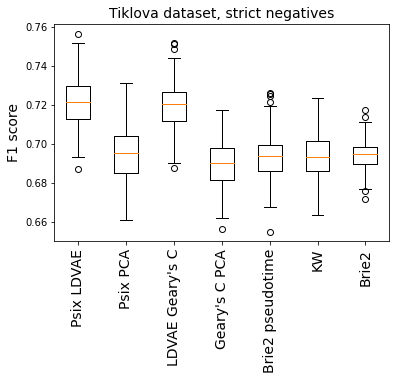

In [11]:
tiklova_boxplots = [ psix_auc, #psix_scvi5_auc, 
                    psix_pc_auc, gearyc2_auc, gearyc_auc, briep_auc, kw_auc, brie_l_auc]


bp = plt.boxplot(tiklova_boxplots)


plt.xticks(np.arange(1, 8), 
           ['Psix LDVAE', #'Psix LDVAE, no correction', 
            'Psix PCA', "LDVAE Geary's C", "Geary's C PCA", 
            'Brie2 pseudotime', 'KW', 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('F1 score', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Tiklova dataset, strict negatives', fontsize=14)

In [12]:
from sklearn.metrics import auc
from sklearn.metrics import f1_score

weyn_pos = weyn_fdr.index[(weyn_ds.max(axis=1) >= 0.2) & (weyn_fdr.min(axis=1) <= 0.05)]
weyn_neg = weyn_fdr.index[(weyn_ds.max(axis=1) < 0.2) | (weyn_fdr.min(axis=1) > 0.05)]

exons = tiklova_psix.index
exons_pos = weyn_pos & exons
exons_neg = weyn_neg & exons


kw_auc = []
psix_auc = []
psix_scvi5_auc = []
psix_pc_auc = []
gearyc_auc = []
gearyc2_auc = []
briep_auc = []
brie_l_auc = []

for sample in tqdm(range(200)):
    pos_choice = np.random.choice(exons_pos, np.int(0.5*len(exons_pos)), replace=False)
    neg_choice = np.random.choice(exons_neg, np.int(0.5*len(exons_neg)), replace=False)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary.index)
    c_y = list((tiklova_geary.loc[pd.Index(pos_choice) & tiklova_geary.index].pval <= 0.05).astype(int)) + list((tiklova_geary.loc[pd.Index(neg_choice) & tiklova_geary.index].pval <= 0.05).astype(int))
    f1 = f1_score(y, c_y)
    gearyc_auc.append(f1)
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_geary2.index) + [0]*len(pd.Index(neg_choice) & tiklova_geary2.index)
    c_y = list((tiklova_geary2.loc[pd.Index(pos_choice) & tiklova_geary2.index].pval <= 0.05).astype(int)) + list((tiklova_geary2.loc[pd.Index(neg_choice) & tiklova_geary2.index].pval <= 0.05).astype(int))
    f1 = f1_score(y, c_y)
    gearyc2_auc.append(f1)
    
    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list((tiklova_psix.loc[pos_choice].pvals <= 0.05).astype(int)) + list((tiklova_psix.loc[neg_choice].pvals <= 0.05).astype(int))
    psix_auc.append(f1_score(y, psix_y))
    
    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list((tiklova_psix_scvi5.loc[pos_choice].pvals <= 0.05).astype(int)) + list((tiklova_psix_scvi5.loc[neg_choice].pvals <= 0.05).astype(int))
    psix_scvi5_auc.append(f1_score(y, psix_y))
    
    y = [1]*len(pos_choice) + [0]*len(neg_choice)
    psix_y = list((tiklova_psix_pca.loc[pos_choice].pvals <= 0.05).astype(int)) + list((tiklova_psix_pca.loc[neg_choice].pvals <= 0.05).astype(int))
    psix_pc_auc.append(f1_score(y, psix_y))
    
    kw_y = list((tiklova_kw.loc[pos_choice].pvals <= 0.05).astype(int)) + list((tiklova_kw.loc[neg_choice].pvals <= 0.05).astype(int))
    kw_auc.append(f1_score(y, kw_y))
    
    r_y = list((tiklova_ovo.loc[[x for x in pos_choice if x in tiklova_ovo.index]]<=0.05).astype(int)) + list((tiklova_ovo.loc[[x for x in neg_choice if x in tiklova_ovo.index]]<=0.05).astype(int))
    brie_l_auc.append(f1_score([1]*len([x for x in pos_choice if x in tiklova_ovo.index]) + [0]*len([x for x in neg_choice if x in tiklova_ovo.index]), r_y))
    #####
    
    y = [1]*len(pd.Index(pos_choice) & tiklova_brie_pseudo.index) + [0]*len(pd.Index(neg_choice) & tiklova_brie_pseudo.index)
    brie_y = list((tiklova_brie_pseudo.loc[pd.Index(pos_choice) & tiklova_brie_pseudo.index].neuro_pval<=0.05).astype(int)) + list((tiklova_brie_pseudo.loc[pd.Index(neg_choice) & tiklova_brie_pseudo.index].neuro_pval<=0.05).astype(int))
    briep_auc.append(f1_score(y, brie_y))
    



100%|██████████| 200/200 [00:13<00:00, 15.21it/s]


Text(0.5, 1.0, 'Tiklova dataset')

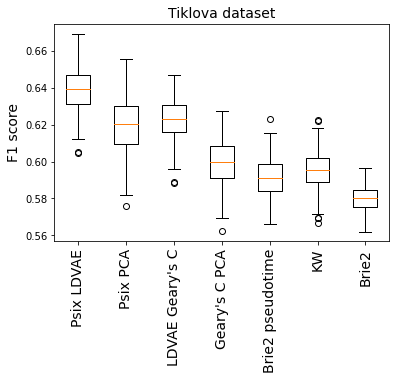

In [13]:
tiklova_boxplots = [ psix_auc, #psix_scvi5_auc, 
                    psix_pc_auc, gearyc2_auc, gearyc_auc, briep_auc, kw_auc, brie_l_auc]


bp = plt.boxplot(tiklova_boxplots)


plt.xticks(np.arange(1, 8), 
           ['Psix LDVAE', #'Psix LDVAE, no correction', 
            'Psix PCA', "LDVAE Geary's C", "Geary's C PCA", 
            'Brie2 pseudotime', 'KW', 'Brie2'], fontsize=14, rotation=90)

plt.ylabel('F1 score', fontsize=14)
# plt.xlabel('Method', fontsize=14)
plt.title('Tiklova dataset', fontsize=14)

Text(0, 0.5, 'PC2 of LDVAE space')

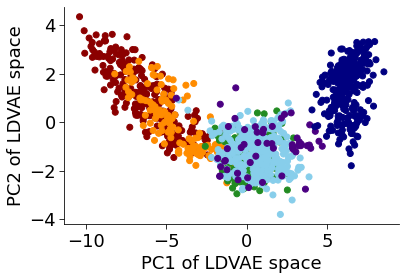

In [14]:
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
colores = []
for cell in tiklova_meta.loc[tiklova_rd.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
pc = PCA(2).fit_transform(tiklova_rd)
fig = plt.figure(figsize=(6, 4))
ax  = plt.subplot(1,1,1)
ax.scatter(-pc.T[0], pc.T[1], c=colores)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.tick_params(labelsize=18, length=5)
plt.xlabel('PC1 of LDVAE space', fontsize=18)
plt.ylabel('PC2 of LDVAE space', fontsize=18)

Text(0, 0.5, 'Component 2')

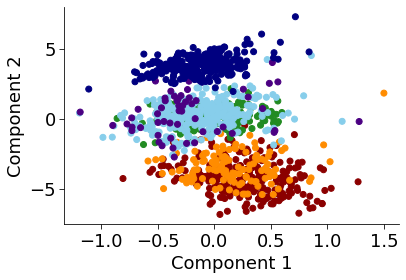

In [15]:
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
colores = []
for cell in tiklova_meta.loc[tiklova_rd.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
pc = PCA(2).fit_transform(tiklova_rd)
fig = plt.figure(figsize=(6, 4))
ax  = plt.subplot(1,1,1)
ax.scatter(tiklova_rd.scvi_5, tiklova_rd.scvi_4, c=colores)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.tick_params(labelsize=18, length=5)
plt.xlabel('Component 1', fontsize=18)
plt.ylabel('Component 2', fontsize=18)

In [30]:
tiklova_rd

,scvi_1,scvi_2,scvi_3,scvi_4,scvi_5
SRR7408400,2.815445,2.213544,-2.678212,-2.365352,0.079998
SRR7408401,4.194799,3.473450,-3.129057,-4.220302,-0.050569
SRR7408404,4.595242,4.248564,-2.041807,-4.626901,0.681469
SRR7408413,3.823493,3.198303,-2.855473,-3.708164,0.028454
SRR7408414,3.775988,4.209371,-2.593978,-4.771865,0.586940
...,...,...,...,...,...
SRR7410092,-2.720989,-2.000029,3.798462,2.680877,-0.076453
SRR7410093,-0.160847,-2.154123,4.208127,2.960118,-0.576721
SRR7410094,-2.016599,-1.940344,4.079000,2.704794,-0.124904
SRR7410096,-0.703893,-2.674496,4.219224,3.478853,-0.437189


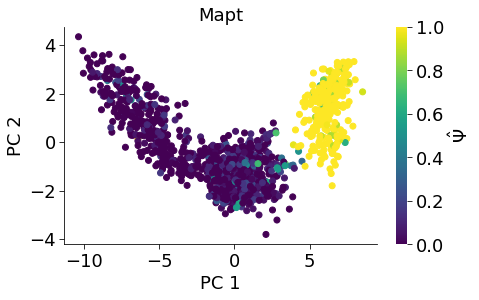

In [16]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(-pc.T[0], pc.T[1], c=tiklova_PSI.loc['Mapt_1'])
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Mapt', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



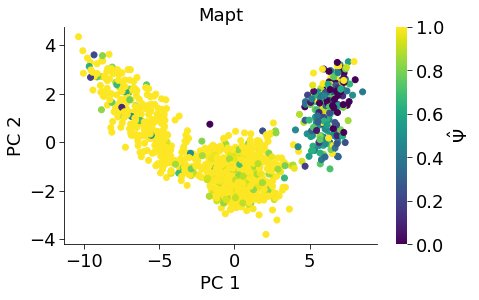

In [17]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(-pc.T[0], pc.T[1], c=tiklova_PSI.loc['Cadm1_10'], cmap='viridis')
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Mapt', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



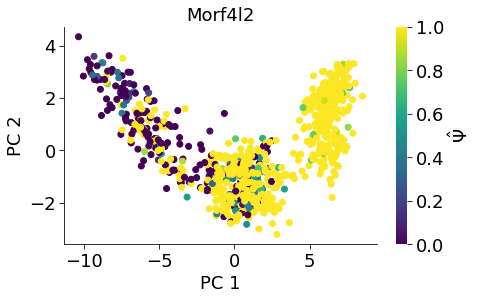

In [18]:
fig = plt.figure(figsize=(7, 4))
ax  = plt.subplot(1,1,1)
sc = ax.scatter(-pc.T[0], pc.T[1], c=tiklova_PSI.loc['Clta_1'])
# cb = plt.colorbar(sc)
ax.tick_params(labelsize=18, length=5)
cb = plt.colorbar(sc, shrink = 1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
plt.title('Morf4l2', fontsize=18)
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



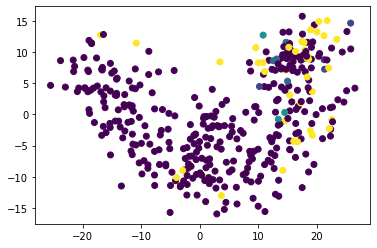

In [11]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Macf1_11'])

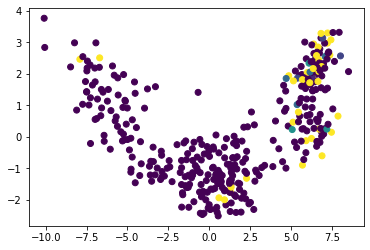

In [69]:
plt.scatter(-pc.T[0], pc.T[1], c=tiklova_PSI.loc['Macf1_11'])


In [19]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix/utils')
import psix_functions as pr

from scipy.special import logit, expit
import hotspot
W = pr.get_distance_matrix(tiklova_rd, k=100)

for exon in W.index:
    W.loc[exon, exon] = 1
    



exon_list = tiklova_psix.loc[(tiklova_psix.L_score > 0) & (tiklova_psix.qvals <= 0.05)].index
# background_psi = get_background(tiklova_PSI, W, exon_list)
background_psi = pd.read_csv('data/background_psi_scvi5_batch.tab.gz', sep='\t', index_col=0)
# background_psi.to_csv('data/background_psi_scvi5_batch.tab.gz', sep='\t', index=True, header=True)

  1%|          | 6/1197 [00:00<00:23, 50.70it/s]

Changed cross function


100%|██████████| 1197/1197 [00:23<00:00, 51.91it/s]


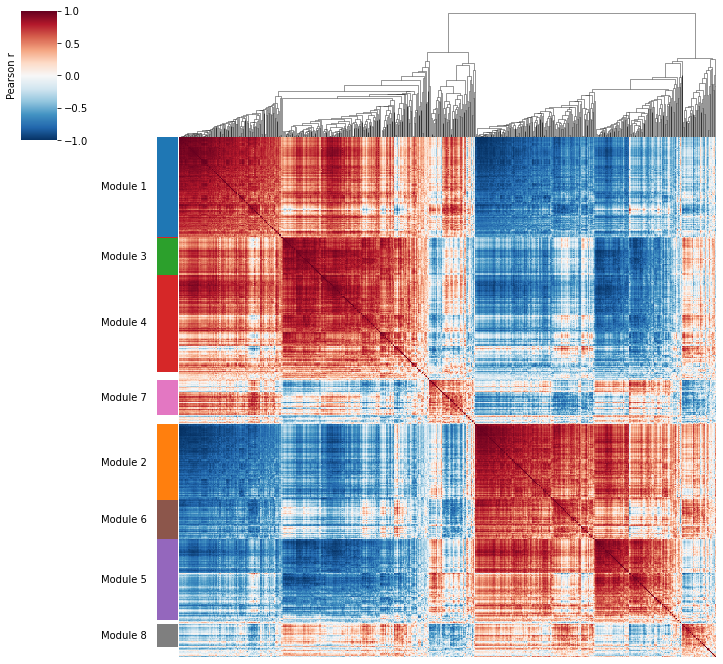

In [46]:
bwow = compute_modules(background_psi.T.corr().fillna(0), 
                min_gene_threshold=30, fdr_threshold=None, z_threshold=0.3, core_only=False)

aver = local_correlation_plot(
            background_psi.T.corr().fillna(0), bwow[0], bwow[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False
)

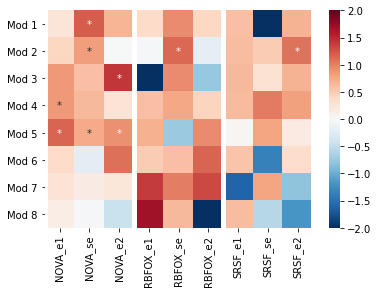

In [52]:
hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 9):
        enrichment = test_enrichment(mouse_clip_families[rbp], bwow[0].index[(bwow[0]==module)])
#         p_enrich.append(np.min((enrichment[0], enrichment[1])))
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['Mod '+ str(x) for x in range(1, 9)]
hyper_pval_enrich.index = ['Mod '+ str(x) for x in range(1, 9)]
hyper_pval_deplete.index = ['Mod '+ str(x) for x in range(1, 9)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[0].reshape(8,-8))
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

# figsize(8, 6)
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [58]:
multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], method='fdr_bh')[0].reshape(8,-9)

array([[False,  True, False, False, False, False, False, False, False],
       [False,  True, False, False,  True, False, False, False,  True],
       [False, False,  True, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False, False],
       [ True,  True,  True, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False]])

(array([28.,  7., 10.,  5.,  4.,  5.,  1.,  3.,  2.,  7.]),
 array([4.29714838e-08, 1.00000039e-01, 2.00000034e-01, 3.00000030e-01,
        4.00000026e-01, 5.00000021e-01, 6.00000017e-01, 7.00000013e-01,
        8.00000009e-01, 9.00000004e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

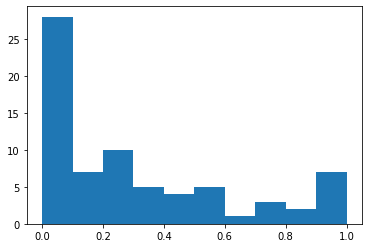

In [65]:
plt.hist(np.array(hyper_pval_enrich).reshape(1, -1)[0])

In [48]:
bwow[0].loc[[x for x in sig_exons if 'Srsf' in x]]

Srsf10_nmdSE_1    4
Srsf9_2           4
Srsf9_nmdSE_1     1
Srsf2_1           4
Srsf11_nmdSE_2    4
Srsf6_1           4
Srsf6_nmdSE_1     4
Srsf9_nmdSE_2     4
Name: Module, dtype: int64

In [369]:
from sklearn.cluster import AgglomerativeClustering
AC = AgglomerativeClustering(6, linkage='average')
clusters = AC.fit_predict(background_psi.T.corr())
modules = pd.DataFrame()
modules['clusters'] = clusters
modules.index = background_psi.index

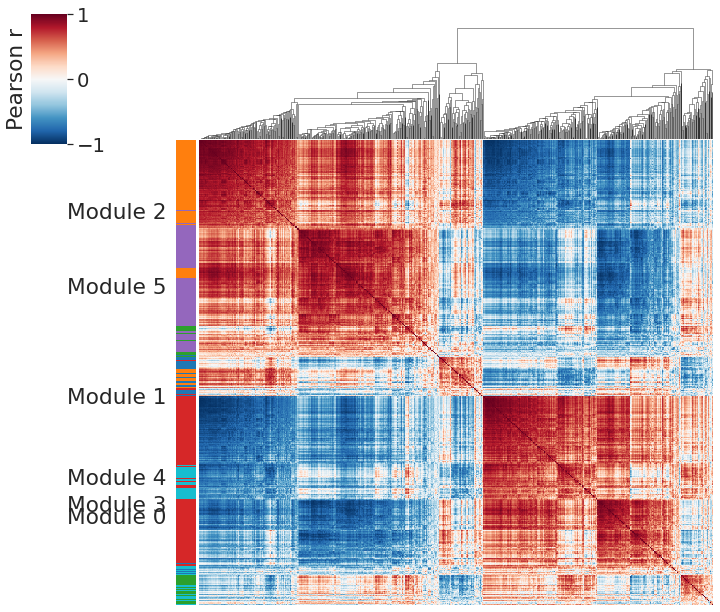

In [370]:
aver = local_correlation_plot(
            background_psi.T.corr().fillna(0), modules.clusters, bwow[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False
)

In [172]:
for i in range(len(bwow[0])):
    if bwow[0].index[i] == 'Zdbf2_1':
        print('Zdbf2_1')
        print(i)
        
    if bwow[0].index[i] == 'Zdbf2_3':
        print('Zdbf2_3')
        print(i)

Zdbf2_1
716
Zdbf2_3
717


In [179]:
bwow[1][715:719]#.mean()

array([[1.44300000e+03, 1.47700000e+03, 4.71430182e-01, 5.00000000e+00],
       [1.47000000e+03, 1.50200000e+03, 4.72044683e-01, 1.52000000e+02],
       [1.49400000e+03, 1.46200000e+03, 4.72970815e-01, 1.03000000e+02],
       [1.49300000e+03, 1.46000000e+03, 4.74220114e-01, 1.90000000e+01]])

In [28]:
motif_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/meme_motifs/'
mouse_motifs_exons = pd.read_csv(motif_dir + 'mouse_rbp.exons.tab', sep='\t', index_col=0)
mouse_motifs_ase = pd.read_csv(motif_dir + 'mouse_rbp.ase.tab', sep='\t', index_col=0)

human_motifs_exons = pd.read_csv(motif_dir + 'human_rbp.exons.tab', sep='\t', index_col=0)
human_motifs_ase = pd.read_csv(motif_dir + 'human_rbp.ase.tab', sep='\t', index_col=0)

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'
mouse_clip_predicted = pd.read_csv(clip_dir + 'peaks_predicted_mRBP.tab', sep='\t', index_col=0)
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags.tab', sep='\t', index_col=0)

mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova_hRBP/'
human_clip_predicted = pd.read_csv(clip_dir + 'peaks_predicted_hRBP.tab', sep='\t', index_col=0)

human_clip_predicted = (human_clip_predicted.loc[[x for x in human_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
human_clip_predicted.index= [x[:-3] for x in human_clip_predicted.index if x[-3:]=='_se']


In [29]:
clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'

mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)

mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']


mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)
exon_lengths = pd.read_csv('~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/exon_lengths.tab', sep='\t',
                           index_col=0, names=['exon', 'ase', 'length']).loc[mouse_clip_peaks.index]
exon_lengths.index == mouse_clip_peaks.index

array([ True,  True,  True, ...,  True,  True,  True])

In [30]:
mouse_clip_overlap = mouse_clip_peaks.divide(exon_lengths.length, axis=0)

exons_sorted = tiklova_psix.sort_values('L_score').index[::-1]

list_modules = []

colores = ['forestgreen', 'indigo', 'brown', 'navy']
# colores_lista = []
# module_list = [1, 2, 3, 4, 5, 6, 7]#[3, 5, 6, 1]
# for i in range(4):
#     lista = list(bwow[0][bwow[0] == module_list[i]].index)
#     list_modules += lista
#     colores_lista.extend([colores[i]]*len(lista))
    
# colores_idx = list(range(len(colores_lista)))
    
# not_there = [x for x in tiklova_psix.index if x not in list_modules]
# list_modules += not_there

# step = len(list_modules)


mouse_clip_overlap = mouse_clip_overlap.loc[[x for x in mouse_clip_overlap.index if x[-3:]=='_se']]
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_overlap.index= [x[:-3] for x in mouse_clip_overlap.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']



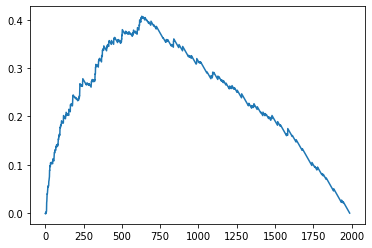

In [31]:
plt.plot(range(len(exons_sorted)),
         enrichment_score(list(mouse_clip_overlap.loc[exons_sorted]['NOVA1'])))

In [47]:
nova_pred = pd.read_csv('~/Network/Mouse/SplicingNetwork/Graphprot/exons.gp.predictions', sep='\t', index_col=0,
                        names=['prediction', 'score'])
exons_bed = pd.read_csv('~/Network/Mouse/SplicingNetwork/Graphprot/exons.bed', sep='\t',
                        names=['chrom', 'start', 'end', 'exon', 'ase', 'strand'])

In [54]:
nova_pred.index = exons_bed.exon
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)


In [77]:
f1 = []
rec = []
for rbp in mouse_clip_peaks.columns:
    f1.append(f1_score((mouse_clip_peaks > 0).astype(int)[rbp], (mouse_clip_predicted > 0).astype(int)[rbp]))
    rec.append(recall_score((mouse_clip_peaks > 0).astype(int)[rbp], (mouse_clip_predicted > 0).astype(int)[rbp]))

Text(0.5, 1.0, 'FInding exons with peaks')

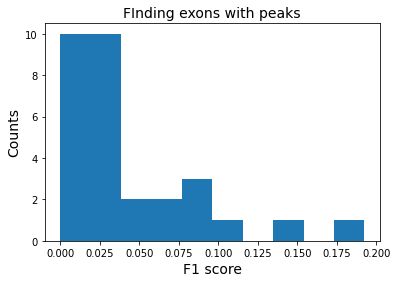

In [80]:
plt.hist(f1)
plt.xlabel('F1 score', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('FInding exons with peaks', fontsize=14)

Text(0.5, 1.0, 'FInding exons with peaks')

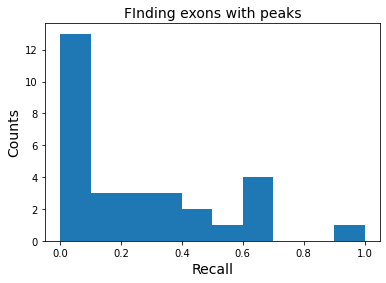

In [81]:
plt.hist(rec)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('FInding exons with peaks', fontsize=14)

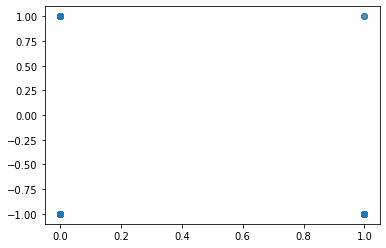

In [63]:
plt.scatter((mouse_clip_peaks.NOVA1 > 0).astype(int), nova_pred.prediction, alpha=0.02)

In [68]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
f1_score((mouse_clip_peaks.NOVA1 > 0).astype(int), (nova_pred.prediction>0).astype(int))

0.0955574182732607

In [69]:
recall_score((mouse_clip_peaks.NOVA1 > 0).astype(int), (nova_pred.prediction>0).astype(int))

0.10363636363636364

Text(0, 0.5, 'ENrichment score')

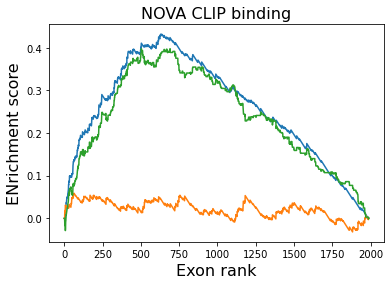

In [200]:
# figsize(6,4)
plt.plot(range(len(list_modules)),enrichment_score(list(mouse_clip_overlap.loc[exons_sorted][['NOVA1', 'NOVA2']].max(axis=1))),
        label='Sorted by Psix')

exp_sorted = tiklova_mrna_event.loc[exons_sorted].mean(axis=1).sort_values().index[::-1]
plt.plot(range(len(list_modules)),enrichment_score(list(mouse_clip_overlap.loc[exp_sorted][['NOVA1', 'NOVA2']].max(axis=1))),
        label='sorted by expression')

plt.plot(range(len(list_modules)),
         enrichment_score(list(mouse_clip_overlap.loc[exons_sorted][['NOVA1', 'NOVA2']].max(axis=1)))-enrichment_score(list(mouse_clip_overlap.loc[exp_sorted][['NOVA1', 'NOVA2']].max(axis=1))),
        label='difference')

plt.title('NOVA CLIP binding', fontsize=16)
plt.xlabel('Exon rank', fontsize=16)
plt.ylabel('ENrichment score',fontsize=16)

In [227]:


hyper_pvals = []
for rbp in mouse_clip_peaks.columns:
    hyper_pvals.append(test_enrichment(mouse_clip_peaks[rbp], bwow[0].index[(bwow[0]==4)])[0])
    
from statsmodels.stats.multitest import multipletests
mouse_clip_peaks.columns[multipletests(hyper_pvals, method='fdr_bh')[0]]


/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


Index(['SRSF4', 'SRSF5', 'SRSF6'], dtype='object')

In [209]:
hyper_pvals = []
for rbp in human_clip_predicted.columns:
    hyper_pvals.append(test_enrichment(human_clip_predicted[rbp], [x for x in sig_exons if ('Srsf' in x) and ('nmdSE' in x)])[0])
    
human_clip_predicted.columns[multipletests(hyper_pvals, method='fdr_bh')[0]]


Index([], dtype='object')

In [99]:
bwow[0].loc[[x for x in sig_exons if 'Srsf' in x]]

Srsf10_nmdSE_1    4
Srsf9_2           4
Srsf9_nmdSE_1     1
Srsf2_1           4
Srsf11_nmdSE_2    4
Srsf6_1           4
Srsf6_nmdSE_1     4
Srsf9_nmdSE_2     4
Name: Module, dtype: int64

In [100]:
mouse_clip_predicted

,RBFOX1,RBFOX2,RBFOX3,RBM3,SRRM4,SRSF1,SRSF2,SRSF3,SRSF4,SRSF5,...,EZH2,FMR1,LIN28A,MBNL1MBNL2,MBNL1,MBNL2,NOVA1,NOVA2,PABPC1,PTBP1


In [98]:
tiklova_psix.loc['Srsf7_nmdSE_1']

bin           mean_3_var_3
L_score          0.0760582
pvals            0.0699301
qvals             0.129442
norm_pvals      0.00646502
norm_qvals             NaN
Name: Srsf7_nmdSE_1, dtype: object

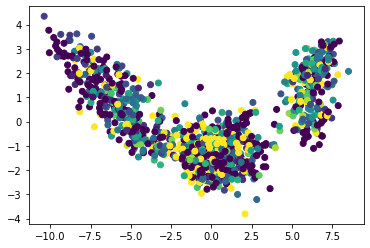

In [225]:
plt.scatter(-pc.T[0], pc.T[1], c=tiklova_PSI.loc['Srsf7_nmdSE_1'])

In [164]:
background_psi.T.corr().loc[['Zdbf2_1', 'Zdbf2_3'], ['Zdbf2_1', 'Zdbf2_3']]

,Zdbf2_1,Zdbf2_3
Zdbf2_1,1.000000,0.928367
Zdbf2_3,0.928367,1.000000


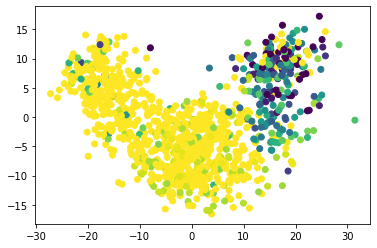

In [21]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Cadm1_10'])

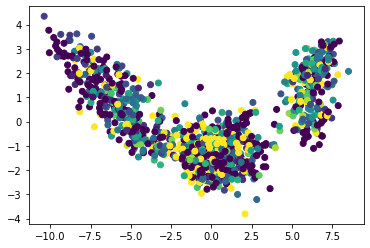

In [217]:
plt.scatter(-pc.T[0], pc.T[1], c=tiklova_PSI.loc['Srsf7_nmdSE_1'])


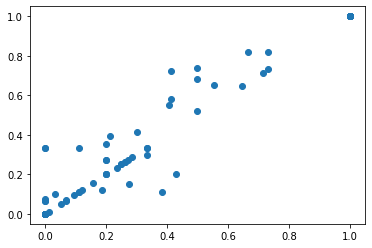

In [167]:
plt.scatter(tiklova_PSI.loc['Zdbf2_1'], tiklova_PSI.loc['Zdbf2_3'])

100%|██████████| 1988/1988 [00:10<00:00, 189.37it/s]


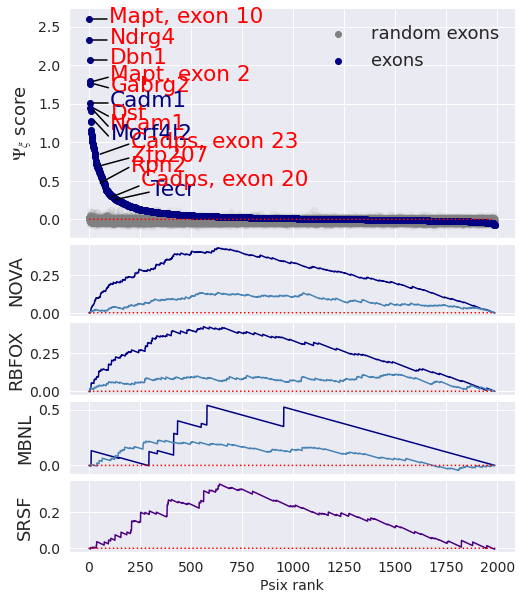

In [253]:
import matplotlib.colors as mcolors


import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

import matplotlib as mpl
# mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["mathtext.fontset"] = "stix"

from IPython.core.pylabtools import figsize
from matplotlib.gridspec import GridSpec
figsize(8, 10) # This is for regular size
# figsize(15, 4)
fig = plt.figure()

# fig.suptitle('p-values of Kruskal-Wallis test', fontsize=28)

gs = GridSpec(7,1)
gs.update(wspace=0.05, hspace=0.10)

ax_joint = fig.add_subplot(gs[0:3,0])

i = 0

#######################
ax_joint.scatter([100], [-0.05], c='gray', label='random exons')

for mean_var in tqdm(tiklova_psix.sort_values('L_score')[::-1].bin):
    subset = np.random.choice(random_df[mean_var], 50, replace=False)
    ax_joint.scatter([i]*50, subset, c='gray', alpha=0.02)
    i += 1


ax_joint.text(100, tiklova_psix.loc['Mapt_1'].L_score-0.05, 'Mapt, exon 10', c='red')   
ax_joint.plot([20, 90], [tiklova_psix.loc['Mapt_1'].L_score, tiklova_psix.loc['Mapt_1'].L_score],c='black')

ax_joint.text(100, tiklova_psix.loc['Ndrg4_1'].L_score-0.05, 'Ndrg4', c='red')   
ax_joint.plot([20, 90], [tiklova_psix.loc['Ndrg4_1'].L_score, tiklova_psix.loc['Ndrg4_1'].L_score],c='black')

ax_joint.text(100, tiklova_psix.loc['Dbn1_1'].L_score-0.05, 'Dbn1', c='red')   
ax_joint.plot([20, 90], [tiklova_psix.loc['Dbn1_1'].L_score, tiklova_psix.loc['Dbn1_1'].L_score],c='black')

ax_joint.text(104, tiklova_psix.loc['Mapt_3'].L_score, 'Mapt, exon 2', c='red')    
ax_joint.plot([24, 94], [tiklova_psix.loc['Mapt_3'].L_score, tiklova_psix.loc['Mapt_3'].L_score+0.05],c='black')
ax_joint.text(105, tiklova_psix.loc['Gabrg2_1'].L_score-0.1, 'Gabrg2', c='red')   
ax_joint.plot([25, 95], [tiklova_psix.loc['Gabrg2_1'].L_score, tiklova_psix.loc['Gabrg2_1'].L_score-0.05],c='black')



ax_joint.text(104, tiklova_psix.loc['Cadm1_10'].L_score-0.05, 'Cadm1', c='navy')    
ax_joint.plot([24, 94], [tiklova_psix.loc['Cadm1_10'].L_score, tiklova_psix.loc['Cadm1_10'].L_score],c='black')
ax_joint.text(105, tiklova_psix.loc['Dst_5'].L_score-0.15, 'Dst', c='red')   
ax_joint.plot([25, 95], [tiklova_psix.loc['Dst_5'].L_score, tiklova_psix.loc['Dst_5'].L_score-0.1],c='black')


ax_joint.text(104, tiklova_psix.loc['Ncam1_6'].L_score-0.25, 'Ncam1', c='red')    
ax_joint.plot([24, 94], [tiklova_psix.loc['Ncam1_6'].L_score, tiklova_psix.loc['Ncam1_6'].L_score-0.2],c='black')
ax_joint.text(105, tiklova_psix.loc['Morf4l2_7'].L_score-0.25, 'Morf4l2', c='navy')   
ax_joint.plot([25, 95], [tiklova_psix.loc['Morf4l2_7'].L_score, tiklova_psix.loc['Morf4l2_7'].L_score-0.2],c='black')

ax_joint.text(305, tiklova_psix.loc['Tecr_6'].L_score+0.05, 'Tecr', c='navy')   
ax_joint.plot([125, 295], [tiklova_psix.loc['Tecr_6'].L_score, tiklova_psix.loc['Tecr_6'].L_score+0.1],c='black')

ax_joint.text(205, tiklova_psix.loc['Rpn2_3'].L_score+0.15, 'Rpn2', c='red')   
ax_joint.plot([55, 195], [tiklova_psix.loc['Rpn2_3'].L_score, tiklova_psix.loc['Rpn2_3'].L_score+0.2],c='black')


ax_joint.text(255, tiklova_psix.loc['Cadps_2'].L_score+0.15, 'Cadps, exon 20', c='red')   
ax_joint.plot([105, 245], [tiklova_psix.loc['Cadps_2'].L_score, tiklova_psix.loc['Cadps_2'].L_score+0.15],c='black')

ax_joint.text(205, tiklova_psix.loc['Cadps_7'].L_score+0.08, 'Cadps, exon 23', c='red')   
ax_joint.plot([55, 195], [tiklova_psix.loc['Cadps_7'].L_score, tiklova_psix.loc['Cadps_7'].L_score+0.13],c='black')

ax_joint.text(205, tiklova_psix.loc['Zfp207_1'].L_score+0.05, 'Zfp207', c='red')   
ax_joint.plot([55, 195], [tiklova_psix.loc['Zfp207_1'].L_score, tiklova_psix.loc['Zfp207_1'].L_score+0.1],c='black')




ax_joint.scatter(np.arange(1, len(tiklova_psix.index)+1), tiklova_psix.sort_values('L_score')[::-1].L_score, c = 'navy',
          label='exons')
    
#plt.xlabel('Psix rank', fontsize=18)
ax_joint.set_ylabel(r'$\Psi_{\xi}$ score', fontsize=18)

plt.legend(frameon=False, fontsize=18)


#######################

ax_1 = fig.add_subplot(gs[3,0])
ax_2 = fig.add_subplot(gs[4,0])
ax_3 = fig.add_subplot(gs[5,0])
ax_4 = fig.add_subplot(gs[6,0])

# ax_5 = fig.add_subplot(gs[4,0])
# ax_6 = fig.add_subplot(gs[5,0])
# ax_7 = fig.add_subplot(gs[6,0])

# ax_1.set_ylim((-0.05,1.05))
# ax_2.set_ylim((-0.05,1.05))
# ax_3.set_ylim((-0.05,1.05))

# ax_1.plot([0, 1], [0, 1], c='gray', linestyle=':')
# ax_2.plot([0, 1], [0, 1], c='gray', linestyle=':')
# ax_3.plot([0, 1], [0, 1], c = 'gray', linestyle=':')

ax_1.plot(range(len(list_modules)),
         enrichment_score(list(mouse_clip_overlap.loc[exons_sorted][['NOVA1', 'NOVA2']].max(axis=1))), c='navy')

ax_1.plot(range(len(list_modules)),enrichment_score(mouse_motifs_ase.loc[exons_sorted, 'Nova1']), c='steelblue')

ax_2.plot(range(len(list_modules)),
         enrichment_score(list(mouse_clip_overlap.loc[exons_sorted][['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))), c='navy')

ax_2.plot(range(len(list_modules)),enrichment_score(mouse_motifs_ase.loc[exons_sorted, 'Rbfox1']), c='steelblue')

ax_3.plot(range(len(list_modules)),
         enrichment_score(list(mouse_clip_overlap.loc[exons_sorted][['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))), 
          c='navy')

ax_3.plot(range(len(list_modules)),enrichment_score(mouse_motifs_ase.loc[exons_sorted, 'Mbnl2']), c='steelblue')

ax_4.plot(range(len(list_modules)),
         enrichment_score(list(mouse_clip_overlap.loc[exons_sorted][['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))), 
          c='indigo')

# ax_5.plot(range(len(list_modules)),
#          enrichment_score(list(mouse_clip_overlap.loc[exons_sorted][['TARDBP']].max(axis=1))), 
#           c='indigo')

# ax_6.plot(range(len(list_modules)),
#          enrichment_score(list(mouse_clip_overlap.loc[exons_sorted][['CELF4']].max(axis=1))), 
#           c='indigo')

# ax_7.plot(range(len(list_modules)),
#          enrichment_score(list(mouse_clip_overlap.loc[exons_sorted][['LIN28A']].max(axis=1))), 
#           c='indigo')

plt.setp(ax_1.get_xticklabels(), visible=False)
plt.setp(ax_2.get_xticklabels(), visible=False)
ax_1.xaxis.set_ticks_position('none')
ax_2.xaxis.set_ticks_position('none')
ax_3.xaxis.set_ticks_position('none')
ax_joint.xaxis.set_ticks_position('none')

ax_4.set_xlabel('Psix rank', fontsize=14)
for ax in [ax_joint, ax_1, ax_2, ax_3, ax_4]:#, ax_5, ax_6, ax_7]:
    ax.tick_params(labelsize=14, length=5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
    ax.plot(range(len(list_modules)),
         [0]*len(list_modules), c='red', linestyle=':')

ax_4.spines["bottom"].set_visible(True)

# ax_1.text(0.05, 1, 'Chen', fontsize=28, verticalalignment='top')
# ax_2.text(0.05, 1, 'Trapnell', fontsize=28, verticalalignment='top')
# ax_3.text(0.05, 1, 'Song', fontsize=28, verticalalignment='top')

ax_1.set_ylabel('NOVA', fontsize = 18)
ax_2.set_ylabel('RBFOX', fontsize = 18)
ax_3.set_ylabel('MBNL', fontsize = 18)
ax_4.set_ylabel('SRSF', fontsize = 18)
# ax_3.set_ylabel('GSEA Enrichment score', fontsize = 18)

plt.show()

In [33]:
mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA'] = mouse_clip_peaks[['NOVA1', 'NOVA2']].max(axis=1)
mouse_clip_families['RBFOX'] = mouse_clip_peaks[['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1)
mouse_clip_families['MBNL'] = mouse_clip_peaks[['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1)
mouse_clip_families['SRSF'] = mouse_clip_peaks[['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1)
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = mouse_clip_peaks.index

In [34]:
mouse_clip_families

,NOVA,RBFOX,MBNL,SRSF
Aamdc_10,0,0,0,0
Aamdc_9,0,0,0,0
Aamdc_nmdSE_2,0,0,0,0
Aasdhppt_2,0,0,0,0
Abat_3,0,0,0,0
...,...,...,...,...
Zmynd8_8,0,0,0,0
Znhit1_1,0,0,0,0
Zscan18_1,0,0,0,0
Zyx_1,0,0,0,0


In [32]:
hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 9):
        enrichment = test_enrichment(mouse_clip_families[rbp], bwow[0].index[(bwow[0]==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['Mod '+ str(x) for x in range(1, 9)]
hyper_pval_enrich.index = ['Mod '+ str(x) for x in range(1, 9)]
hyper_pval_deplete.index = ['Mod '+ str(x) for x in range(1, 9)]
    
        
    
from statsmodels.stats.multitest import multipletests

hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[0].reshape(8,-8))
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

NameError: name 'mouse_clip_families' is not defined

In [282]:
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[0].reshape(8,-8))
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance[['NOVA', 'RBFOX', 'SRSF']].copy()
for exon in hyper_enrich_significance.index:
    for rbp in ['NOVA', 'RBFOX', 'SRSF']:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
            
labels

ValueError: cannot reshape array of size 54 into shape (8,newaxis)

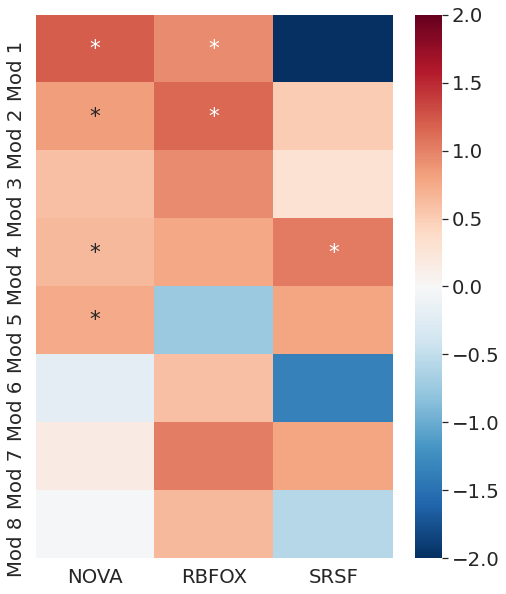

In [264]:
sns.set(font_scale=1.8)
sns.heatmap(hyper_enrichment[['NOVA', 'RBFOX', 'SRSF']], cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')

In [275]:
mouse_pvals = []
for rbp in mouse_clip_overlap.columns:
    mouse_pvals.append(gsea(list(mouse_clip_overlap.loc[exons_sorted][rbp]))[1])

 29%|██▉       | 580/2000 [00:01<00:03, 405.73it/s]


KeyboardInterrupt: 

In [ ]:
from statsmodels.stats.multitest import multipletests
sig_gsea = multipletests(mouse_pvals, method='fdr_bh')[0]

for i in range(len(mouse_clip_peaks.columns)):
    if sig_gsea[i]:
        print(mouse_clip_peaks.columns[i])
        plt.plot(range(len(list_modules)),enrichment_score(list(mouse_clip_peaks.loc[exons_sorted][mouse_clip_peaks.columns[i]])))
        plt.show()

In [35]:
clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
se_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_se']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']


mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_se'] = np.array(mouse_clip_peaks.loc[se_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_se')]


# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']


In [383]:
hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 9):
        enrichment = test_enrichment(mouse_clip_families[rbp], bwow[0].index[(bwow[0]==module)])
        p_enrich.append(np.min((enrichment[0], enrichment[1])))
#         p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['Mod '+ str(x) for x in range(1, 9)]
hyper_pval_enrich.index = ['Mod '+ str(x) for x in range(1, 9)]
hyper_pval_deplete.index = ['Mod '+ str(x) for x in range(1, 9)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[0].reshape(8,-8))
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

figsize(8, 6)
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [373]:
modules#==module

,clusters
Agrn_8,5
Bclaf1_1,5
Camta1_5,2
Ccdc136_17,5
Dlg4_3,2
...,...
Mapt_1,2
Meg3_2,4
Nnat_2,4
Nnat_3,4


In [365]:
test_enrichment(mouse_clip_families['RBFOX_e2'], [x for x in sig_exons if ('nmdSE' in x)])

(0.22386090258724717, 0.9069429796880457, 0.7172584565423705)

In [306]:
nmd_exons = [x for x in tiklova_psix.index if 'nmdSE' in x]

In [307]:
test_enrichment(mouse_clip_families.loc[nmd_exons, 'SRSF_se'], [x for x in nmd_exons if x in sig_exons])

(0.16260131997840588, 0.9362560967934583, 0.42904435727272316)

In [305]:
test_enrichment(mouse_clip_families['SRSF_se'], [x for x in tiklova_psix.index if 'nmdSE' in x])

(0.009444779850789798, 0.9961401229017934, 0.9345771446549467)

In [302]:
test_enrichment(mouse_clip_families['SRSF_se'], sig_exons)

(0.06862907115907217, 0.955644695613383, 0.281266625248733)

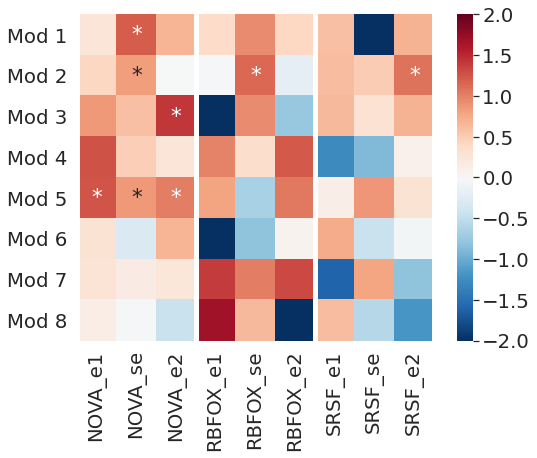

In [384]:
figsize(8, 6)
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [386]:
bwow[0].loc[[x for x in sig_exons if ('nmdSE' in x) and ('Srsf' in x)]]

Srsf10_nmdSE_1   -1
Srsf9_nmdSE_1     1
Srsf11_nmdSE_2   -1
Srsf6_nmdSE_1    -1
Srsf9_nmdSE_2     4
Name: Module, dtype: int64

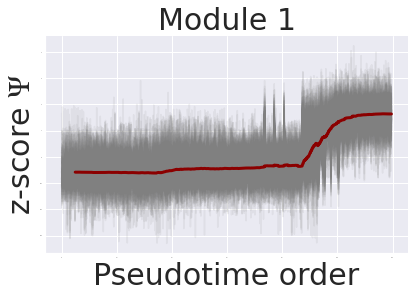

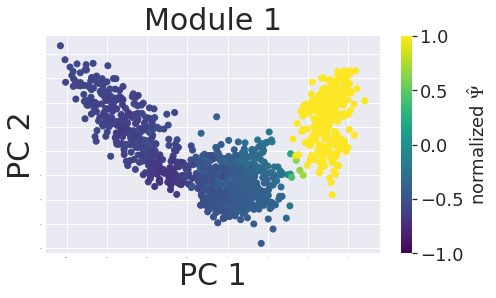

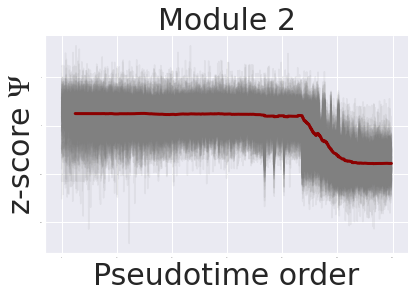

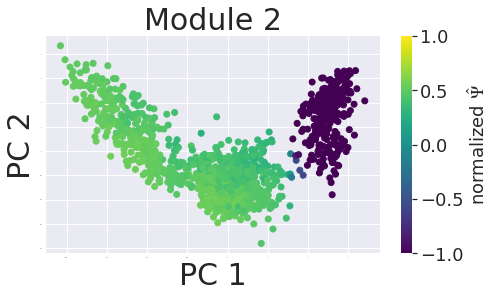

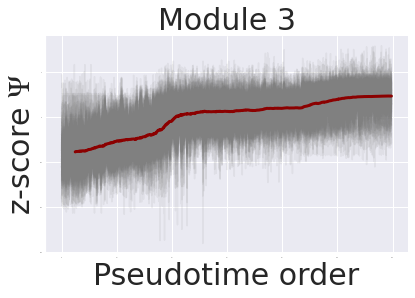

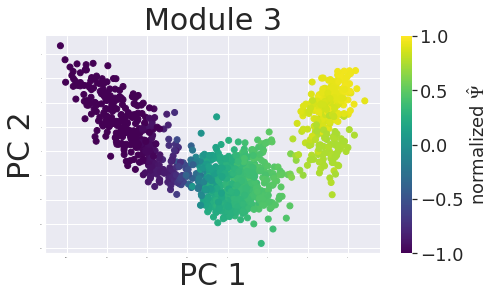

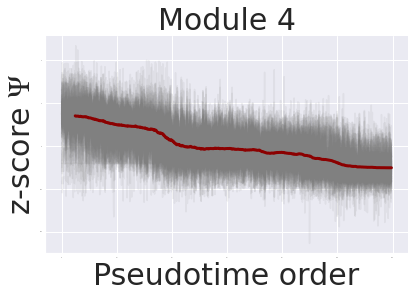

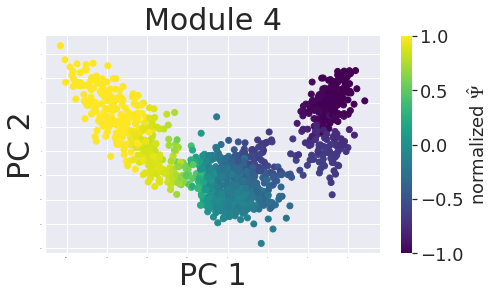

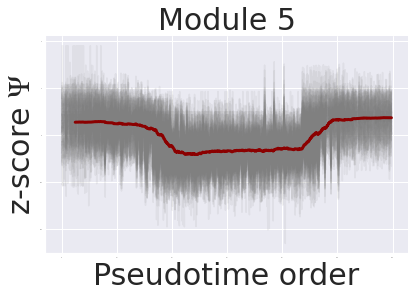

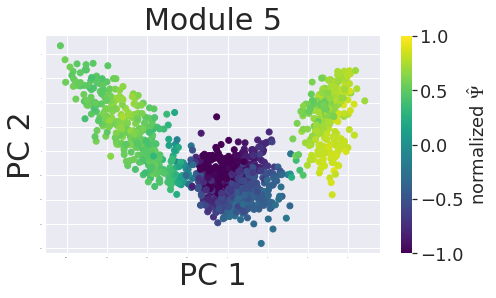

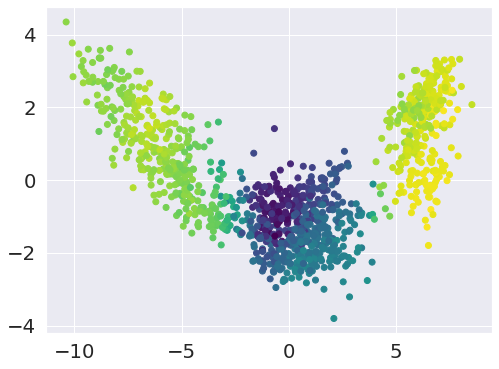

In [298]:
for mod in range(1, 6):
    fig = plt.figure(figsize=(6.5, 4))
    ax  = plt.subplot(1,1,1)

    sorted_cells = tiklova_pseudotime.sort_values('lineage_1_pseudotime').index
    mad_df = pd.DataFrame()
    for exon in bwow[0].index[bwow[0]==mod]:
        mad_df[exon] = zscore(background_psi.loc[exon])
        plt.plot(range(len(sorted_cells)),#tiklova_pseudotime.loc[sorted_cells].lineage_1_pseudotime, 
                 zscore(background_psi.loc[exon, sorted_cells]), 
                 c='gray', alpha=0.1)

    mad_df.index= tiklova_PSI.columns
    plt.plot(range(len(sorted_cells)),##tiklova_pseudotime.loc[sorted_cells].lineage_1_pseudotime, 
             mad_df.loc[sorted_cells].mean(axis=1).rolling(50).mean(), 
                 c='darkred', linewidth=3)
    plt.xlabel('Pseudotime order', fontsize=30)
    plt.ylabel(r'z-score $\Psi$', fontsize=30)



    ax.tick_params(labelsize=0, length=0)
    plt.title('Module '+str(mod), fontsize=30)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.show()
    
    fig = plt.figure(figsize=(7.5, 4))
    ax  = plt.subplot(1,1,1)
    sc = ax.scatter(-pc.T[0], pc.T[1], c=mad_df.mean(axis=1), vmin=-1, vmax=1, cmap='viridis')
    
    cb = plt.colorbar(sc, shrink = 1)
    cb.set_label(label='normalized $\hat{\Psi}$',size=18)
    cb.ax.tick_params(labelsize=18, length=5)
    cb.outline.set_visible(False)
    plt.title('Module '+str(mod), fontsize=30)
    plt.xlabel('PC 1', fontsize=30)
    plt.ylabel('PC 2', fontsize=30)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=0, length=0)
    plt.show()



plt.scatter(-pc.T[0], pc.T[1], c=mad_df.mean(axis=1), cmap='viridis')
plt.show()

# for exon in bwow[0].index[bwow[0]==7]:
#     plt.plot(tiklova_pseudotime.lineage_1_pseudotime, zscore(background_psi.loc[exon]), c='gray', alpha=0.05)
    
# plt.plot()